In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai

In [3]:
from pathlib import Path
import pickle
from PIL import Image

import matplotlib.pyplot as plt

from fastai.vision import ImageDataBunch
from fastai.vision import LabelLists
from fastai.vision import get_transforms

In [4]:
import torch; torch.__version__

'1.1.0'

In [5]:
cifar100_stats = (torch.tensor([0.5070751592371323, 0.48654887331495095, 0.4409178433670343]),
 torch.tensor([0.26733428587924035, 0.2564384629170881, 0.2761504713256853]))

In [6]:
path = Path('cifar100')
train_file = 'train'
test_file = 'test'

In [7]:
data = ImageDataBunch.from_folder(path,
                                  train=f'train_data',
                                  valid=f'valid_data',
                                  ds_tfms=get_transforms(),
                                  num_workers=10,
                                  bs=1024,
                                 ).normalize(cifar100_stats)


CPU times: user 4.83 s, sys: 894 ms, total: 5.73 s
Wall time: 5.23 s


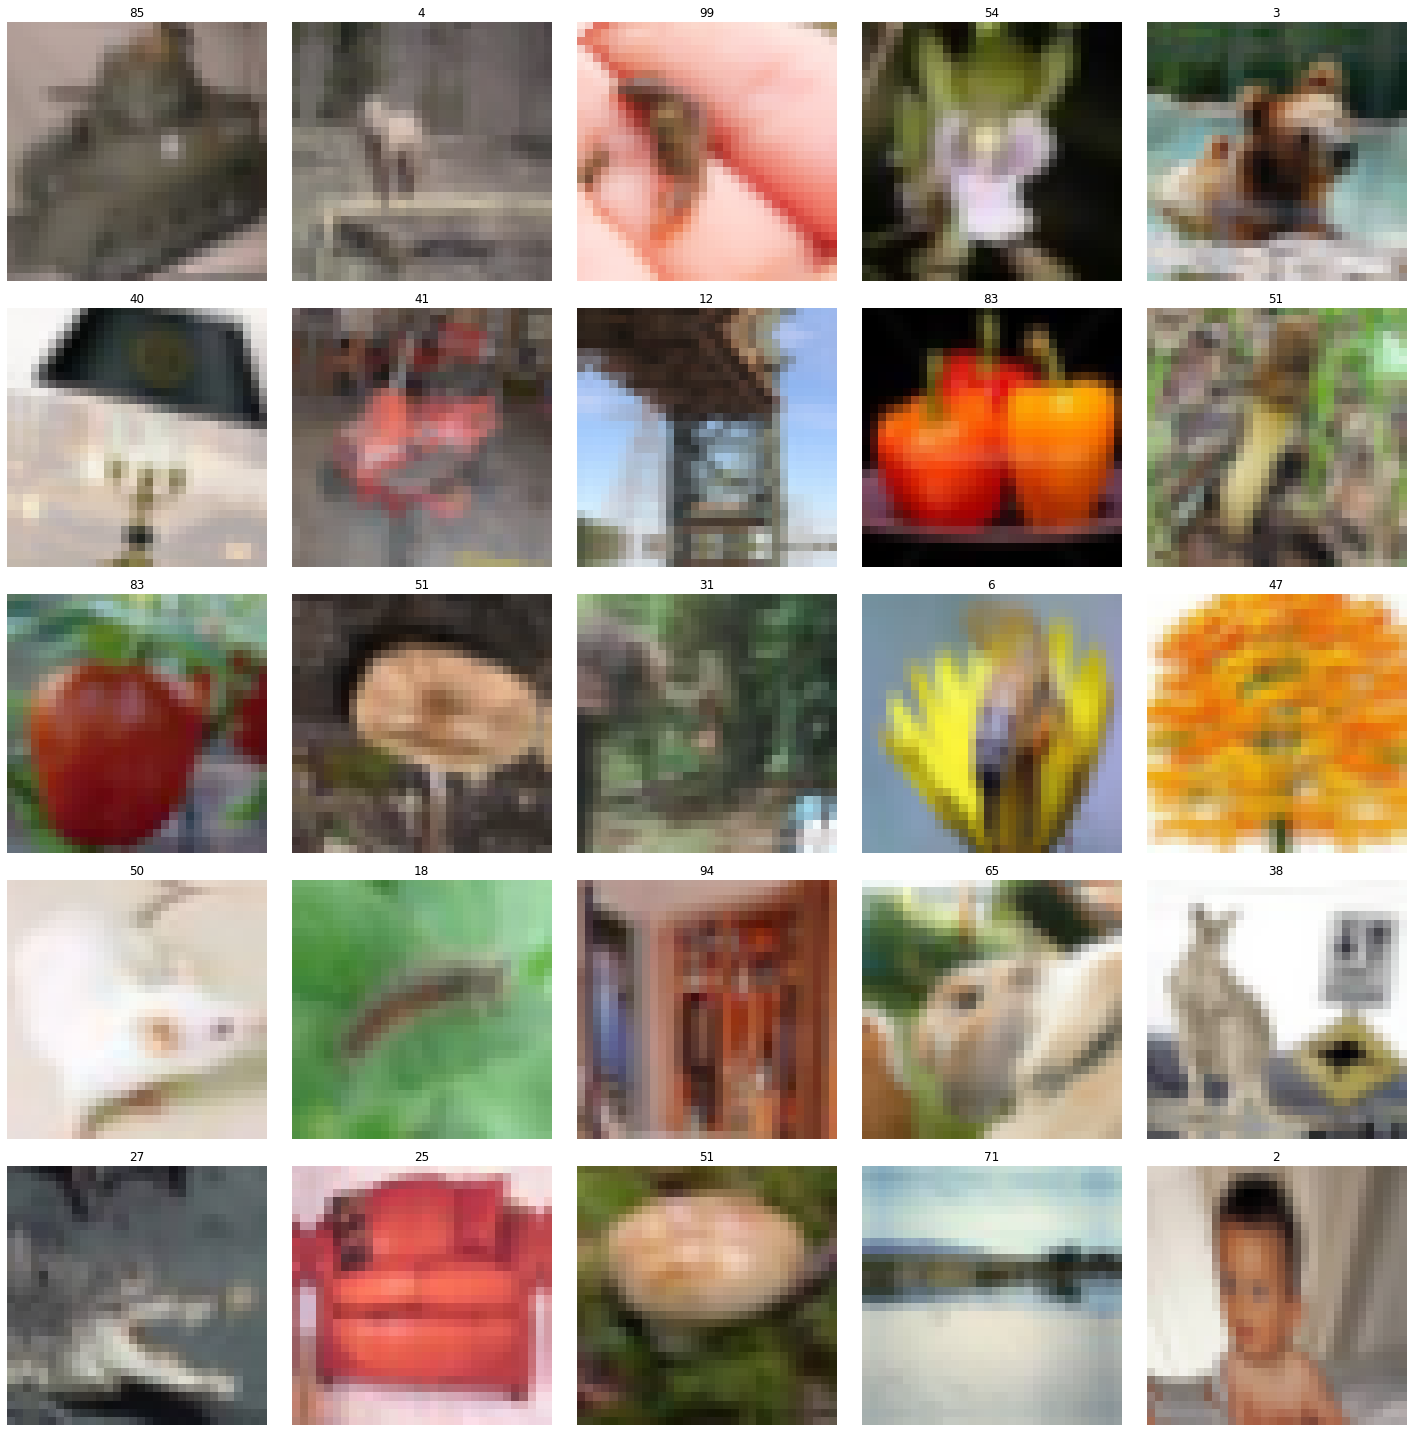

In [8]:
%%time
data.show_batch()

In [9]:
from torchvision import models
from fastai.vision import cnn_learner, accuracy

In [10]:
from torch import nn
from torchsummary import summary

In [11]:
from drn import drn_d_24

In [12]:
learn = cnn_learner(data, drn_d_24, metrics=[accuracy], pretrained=False).mixup()

In [14]:
# for n, m in learn.model.named_parameters():
#     print(m.requires_grad)

In [15]:
summary(learn.model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]           2,352
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           2,304
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 32, 16, 16]           4,608
       BatchNorm2d-8           [-1, 32, 16, 16]              64
              ReLU-9           [-1, 32, 16, 16]               0
           Conv2d-10             [-1, 64, 8, 8]          18,432
      BatchNorm2d-11             [-1, 64, 8, 8]             128
             ReLU-12             [-1, 64, 8, 8]               0
           Conv2d-13             [-1, 64, 8, 8]          36,864
      BatchNorm2d-14             [-1, 6

In [18]:
from fastai.vision import create_body

create_body(module, True, -1)

In [15]:
# learn.load('resnet_18_focal_loss2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


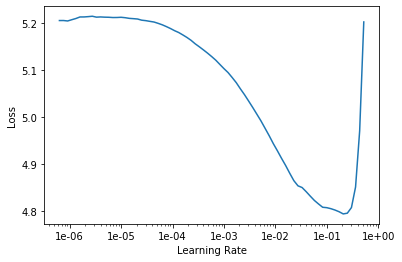

In [19]:
learn.lr_find()
learn.recorder.plot()

In [16]:
from fastai.callbacks import SaveModelCallback
from torch import nn
import torch.nn.functional as F

####  Focal Loss

In [17]:
## code from http://www.hawia.xyz/2019/01/12/Losses%20of%20Pytorch%20and%20Focal%20Loss/

class FocalLoss(nn.Module):
    def __init__(self, gamma=2, weight=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.weight = weight

    def forward(self, input, target, reduction):
        """
        input: [N, C], float32
        target: [N, ], int64
        """
        logpt = F.log_softmax(input, dim=1)
        pt = torch.exp(logpt)
        logpt = (1-pt) ** self.gamma * logpt
        loss = F.nll_loss(logpt, target, self.weight, reduction)
        return loss

In [18]:
# set focal loss
focal_loss = FocalLoss()
learn.loss_func = focal_loss

In [19]:
torch.cuda.is_available()

True

In [21]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learn.fit_one_cycle(200, 1e-2, callbacks=SaveModelCallback(learn, name='DRNET-26'), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,4.524184,4.128023,0.064000,00:21
1,4.307884,3.709198,0.116600,00:19
2,4.130671,3.552496,0.144500,00:20
3,3.997396,3.508030,0.148300,00:20
4,3.877834,3.221445,0.192100,00:20
5,3.773067,3.138920,0.198700,00:20
6,3.689268,3.106067,0.218700,00:20
7,3.611012,2.932149,0.229800,00:20
8,3.531113,2.877431,0.238300,00:20
9,3.471810,2.770983,0.256000,00:20


Better model found at epoch 0 with valid_loss value: 4.128023147583008.
Better model found at epoch 1 with valid_loss value: 3.709197998046875.
Better model found at epoch 2 with valid_loss value: 3.5524957180023193.
Better model found at epoch 3 with valid_loss value: 3.5080296993255615.
Better model found at epoch 4 with valid_loss value: 3.221444606781006.
Better model found at epoch 5 with valid_loss value: 3.1389200687408447.
Better model found at epoch 6 with valid_loss value: 3.106066942214966.
Better model found at epoch 7 with valid_loss value: 2.9321491718292236.
Better model found at epoch 8 with valid_loss value: 2.8774306774139404.
Better model found at epoch 9 with valid_loss value: 2.7709827423095703.
Better model found at epoch 10 with valid_loss value: 2.6754722595214844.
Better model found at epoch 11 with valid_loss value: 2.641832113265991.
Better model found at epoch 13 with valid_loss value: 2.459319829940796.
Better model found at epoch 15 with valid_loss value: 

In [22]:
learn.save('DRNET22-200')

/home/divyansh/.conda/envs/torch/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


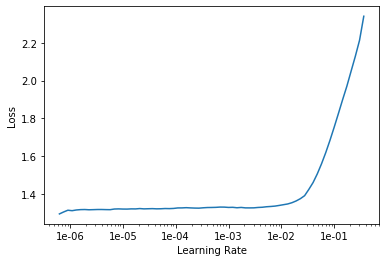

In [23]:
learn.lr_find()
learn.recorder.plot()

In [29]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learn.fit_one_cycle(200, 1e-3, callbacks=SaveModelCallback(learn, name='DRNET22'), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,1.334570,1.139792,0.672500,00:20
1,1.325988,1.138140,0.672600,00:20
2,1.322971,1.140874,0.673700,00:20
3,1.324074,1.142497,0.671800,00:20
4,1.325206,1.141055,0.672800,00:19
5,1.316245,1.138631,0.673500,00:20
6,1.318240,1.142995,0.672700,00:19
7,1.311314,1.141441,0.672700,00:20
8,1.313173,1.142094,0.673700,00:20
9,1.314234,1.135544,0.674100,00:20


Better model found at epoch 0 with valid_loss value: 1.13979172706604.
Better model found at epoch 1 with valid_loss value: 1.1381398439407349.
Better model found at epoch 9 with valid_loss value: 1.1355443000793457.
Better model found at epoch 17 with valid_loss value: 1.134138584136963.


In [32]:
learn.load('resnet_18_focal_loss2');

In [33]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learn.fit_one_cycle(200, 1e-3, callbacks=SaveModelCallback(learn, name='resnet_18_focal_loss2'), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,1.517546,1.429511,0.669600,00:17
1,1.507275,1.413386,0.671500,00:17
2,1.495315,1.395798,0.671300,00:17
3,1.485747,1.379543,0.673000,00:18
4,1.474151,1.364876,0.672800,00:17
5,1.460931,1.354243,0.673100,00:17
6,1.449556,1.343997,0.672800,00:18
7,1.440124,1.336930,0.673000,00:18
8,1.432185,1.335551,0.674200,00:18
9,1.423800,1.333044,0.674300,00:17


Better model found at epoch 0 with valid_loss value: 1.4295111894607544.
Better model found at epoch 1 with valid_loss value: 1.4133862257003784.
Better model found at epoch 2 with valid_loss value: 1.3957982063293457.
Better model found at epoch 3 with valid_loss value: 1.3795428276062012.
Better model found at epoch 4 with valid_loss value: 1.3648756742477417.
Better model found at epoch 5 with valid_loss value: 1.3542433977127075.
Better model found at epoch 6 with valid_loss value: 1.3439967632293701.
Better model found at epoch 7 with valid_loss value: 1.3369300365447998.
Better model found at epoch 8 with valid_loss value: 1.3355505466461182.
Better model found at epoch 9 with valid_loss value: 1.3330435752868652.
Better model found at epoch 10 with valid_loss value: 1.3328150510787964.
Better model found at epoch 112 with valid_loss value: 1.3323487043380737.
Better model found at epoch 127 with valid_loss value: 1.3284796476364136.
Better model found at epoch 128 with valid_los

In [35]:
from fastai.callbacks import ReduceLROnPlateauCallback

In [41]:
cb = ReduceLROnPlateauCallback(learn, patience=5, factor=0.5)

In [43]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learn.fit_one_cycle(200, 1e-3, callbacks=SaveModelCallback(learn, name='resnet_18_focal_loss2'), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,1.712098,2.820930,0.402000,00:17
1,1.692564,2.119849,0.521300,00:17
2,1.675956,1.973245,0.549700,00:17
3,1.653836,1.911193,0.561600,00:17
4,1.629140,1.864846,0.570300,00:17
5,1.599716,1.826674,0.577200,00:17
6,1.572340,1.791006,0.584600,00:17
7,1.543894,1.754567,0.590800,00:17
8,1.517390,1.720562,0.598500,00:18
9,1.486276,1.685708,0.608100,00:17


Better model found at epoch 0 with valid_loss value: 2.820929527282715.
Better model found at epoch 1 with valid_loss value: 2.11984920501709.
Better model found at epoch 2 with valid_loss value: 1.9732446670532227.
Better model found at epoch 3 with valid_loss value: 1.911192774772644.
Better model found at epoch 4 with valid_loss value: 1.8648464679718018.
Better model found at epoch 5 with valid_loss value: 1.826673984527588.
Better model found at epoch 6 with valid_loss value: 1.7910062074661255.
Better model found at epoch 7 with valid_loss value: 1.75456702709198.
Better model found at epoch 8 with valid_loss value: 1.72056245803833.
Better model found at epoch 9 with valid_loss value: 1.6857081651687622.
Better model found at epoch 10 with valid_loss value: 1.651167631149292.
Better model found at epoch 11 with valid_loss value: 1.6211827993392944.
Better model found at epoch 12 with valid_loss value: 1.5911500453948975.
Better model found at epoch 13 with valid_loss value: 1.56

In [44]:
learn.save('focal2')

In [37]:
from fastai.vision import ClassificationInterpretation

In [38]:
interp = ClassificationInterpretation.from_learner(learn)

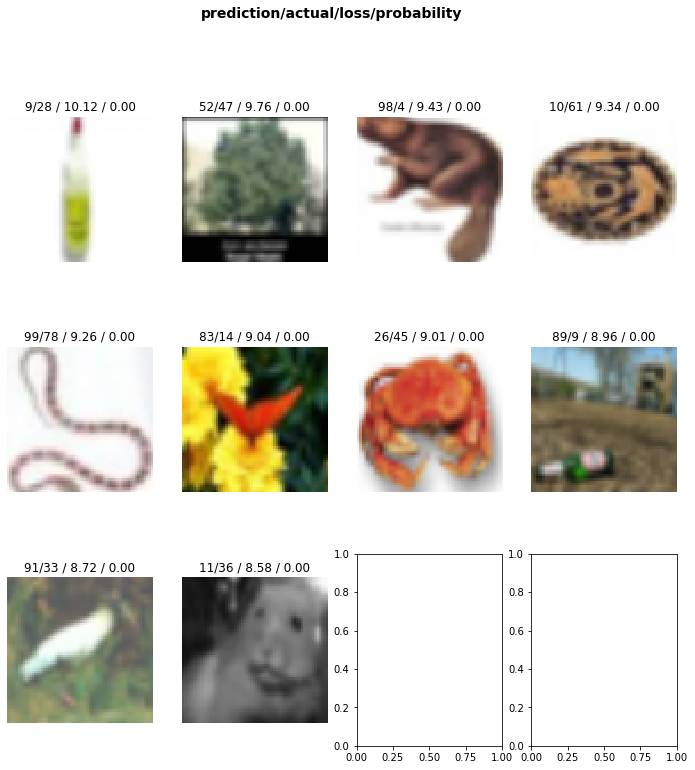

In [40]:
interp.plot_top_losses(10, heatmap=True)

In [57]:
learn.fit_one_cycle(220, 6e-3, callbacks=SaveModelCallback(learn, name='resnet18_96__'), start_epoch=180, wd=0.1)

Model resnet18_96___179 not found.


epoch,train_loss,valid_loss,error_rate,accuracy,time
180,1.109538,1.212131,0.291400,0.708600,10:31
181,1.123748,1.206399,0.291200,0.708800,10:27
182,1.123520,1.196451,0.286100,0.713900,10:33
183,1.123557,1.203960,0.287800,0.712200,10:37
184,1.120785,1.189389,0.283300,0.716700,10:43
185,1.120251,1.191710,0.284500,0.715500,10:46
186,1.121703,1.191914,0.283900,0.716100,11:08
187,1.112743,1.173061,0.282100,0.717900,10:50
188,1.110120,1.180446,0.283800,0.716200,10:45
189,1.114519,1.180402,0.286400,0.713600,10:50


Better model found at epoch 180 with valid_loss value: 1.2121307849884033.
Better model found at epoch 181 with valid_loss value: 1.2063989639282227.
Better model found at epoch 182 with valid_loss value: 1.1964513063430786.
Better model found at epoch 184 with valid_loss value: 1.189388632774353.
Better model found at epoch 187 with valid_loss value: 1.173061490058899.
Better model found at epoch 190 with valid_loss value: 1.1564682722091675.


KeyboardInterrupt: 